### IMPORT LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.preprocessing.image import load_img, img_to_array

### IMPORT / VIEWING / PREPROCESSING DATASET

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


> `DATA AUGMENTATION`

In [3]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=30,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [4]:
train_dataset  = train_datagen.flow_from_directory(directory = 'drive/MyDrive/Alzheimer_s Dataset/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 128)

Found 4114 images belonging to 4 classes.


In [5]:
valid_dataset = valid_datagen.flow_from_directory(directory = 'drive/MyDrive/Alzheimer_s Dataset/train',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 128)

Found 1027 images belonging to 4 classes.


### MODEL BUILDING

In [ ]:
# Model Initialization

base_model = DenseNet169(input_shape=(224,224,3), 
                         include_top=False,
                         weights="imagenet")

51877672/51877672 [==============================] - 3s 0us/step


In [ ]:
# Freezing Layers

for layer in base_model.layers:
    layer.trainable=False

In [ ]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))

In [ ]:
# Summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 dropout (Dropout)           (None, 7, 7, 1664)        0         
                                                                 
 flatten (Flatten)           (None, 81536)             0         
                                                                 
 batch_normalization (BatchN  (None, 81536)            326144    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 2048)              166987776 
                                                                 
 batch_normalization_1 (Batc  (None, 2048)             8192      
 hNormalization)                                        

In [ ]:
# Model Compile 

OPT    = tensorflow.keras.optimizers.Adam(lr=0.001)

model.compile(loss='categorical_crossentropy',
              metrics=[tensorflow.keras.metrics.AUC(name = 'auc')],
              optimizer=OPT)

In [ ]:
# Defining Callbacks

filepath = './best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [ ]:
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 5,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/5
33/33 [==============================] - ETA: 0s - loss: 1.3473 - auc: 0.7869  
Epoch 1: val_auc improved from -inf to 0.69311, saving model to ./best_weights.hdf5
33/33 [==============================] - 3658s 110s/step - loss: 1.3473 - auc: 0.7869 - val_loss: 4.6611 - val_auc: 0.6931
Epoch 2/5
33/33 [==============================] - ETA: 0s - loss: 1.1044 - auc: 0.8280 
Epoch 2: val_auc did not improve from 0.69311
33/33 [==============================] - 1446s 44s/step - loss: 1.1044 - auc: 0.8280 - val_loss: 3.6023 - val_auc: 0.6828
Epoch 3/5
33/33 [==============================] - ETA: 0s - loss: 0.9708 - auc: 0.8544 
Epoch 3: val_auc did not improve from 0.69311
33/33 [==============================] - 1453s 44s/step - loss: 0.9708 - auc: 0.8544 - val_loss: 1.9630 - val_auc: 0.6772
Epoch 4/5
33/33 [==============================] - ETA: 0s - loss: 0.9087 - auc: 0.8625 
Epoch 4: val_auc improved from 0.69311 to 0.75026, saving model to ./best_weights.hdf5
33/33 [======

In [ ]:
model.save('/content/drive/MyDrive/model')

In [6]:
import tensorflow as tf
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/model')

### MODEL EVALUATION

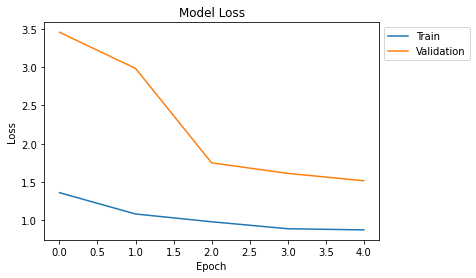

In [ ]:
# Summarize history for loss

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

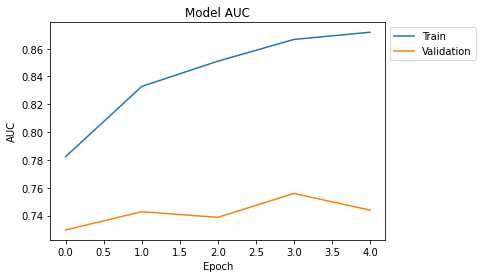

In [ ]:
# Summarize history for AUC

plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [7]:
# Test Data 

test_dataset  = test_datagen.flow_from_directory(directory = 'drive/MyDrive/Alzheimer_s Dataset/test',
                                                 target_size = (224,224),
                                                 class_mode = 'categorical',
                                                 batch_size = 128)

Found 1279 images belonging to 4 classes.


In [8]:
# Evaluating Loss and AUC

loaded_model.evaluate(test_dataset)

10/10 [==============================] - 302s 30s/step - loss: 0.9538 - auc: 0.8563


[0.9538397789001465, 0.8562548160552979]

1/1 [==============================] - 0s 274ms/step
76.32 % chances are there that the image is NonDemented


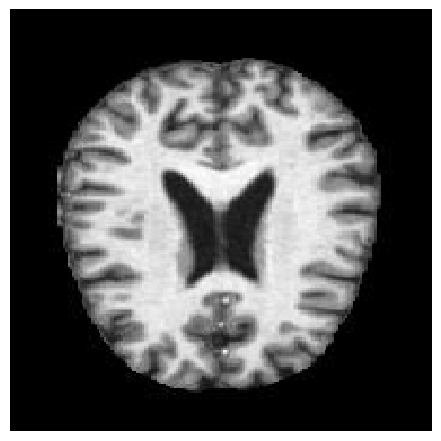

In [9]:
# Test Case 1: Non-Dementia

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('drive/MyDrive/Alzheimer_s Dataset/test/NonDemented/26 (100).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = (loaded_model.predict(img) > 0.5).astype("int32")
probability = round(np.max(loaded_model.predict(img)*100),2)


print(probability, '% chances are there that the image is',idc[np.argmax(answer[0])])

The image has been classified as non-Demented type. The person does not have Alzheimer's disease.

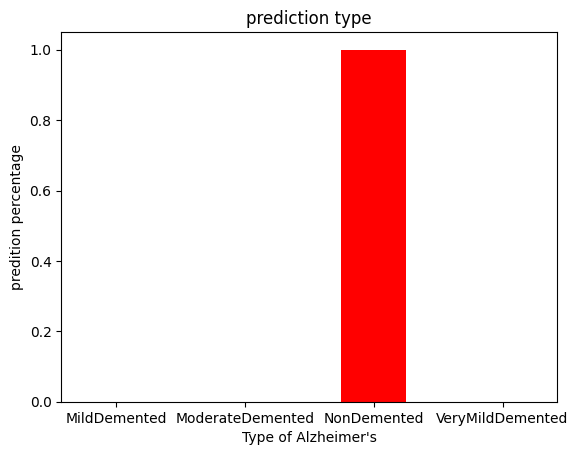

In [10]:
plt.bar(idc.values(), answer[0], width = 0.5, color = ['red'])
plt.xlabel("Type of Alzheimer's")
plt.ylabel("predition percentage")
plt.title("prediction type")
plt.show()

1/1 [==============================] - 0s 299ms/step
65.59 % chances are there that the image is MildDemented


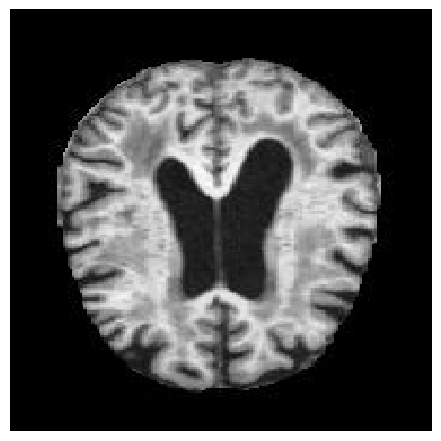

In [21]:
# Test Case 2: Mild Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('drive/MyDrive/Alzheimer_s Dataset/test/MildDemented/26 (24).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = (loaded_model.predict(img) > 0.5).astype("int32")
probability = round(np.max(loaded_model.predict(img)*100),2)

print(probability, '% chances are there that the image is',idc[np.argmax(answer[0])])

The image has been classified as Mild Demented type.
The person has mild trace of Alzheimer's disease .

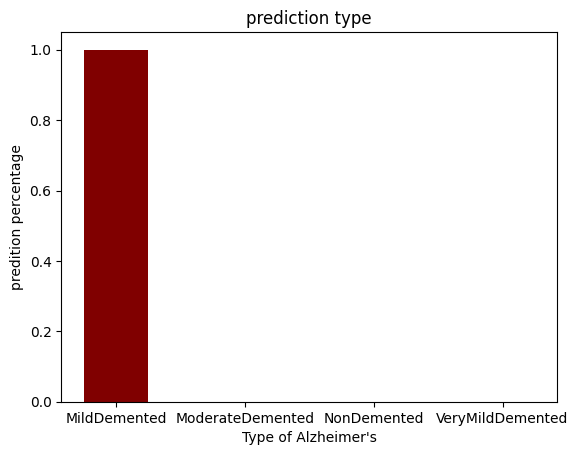

In [22]:
plt.bar(idc.values(), answer[0], width = 0.5, color = ['maroon'])
plt.xlabel("Type of Alzheimer's")
plt.ylabel("predition percentage")
plt.title("prediction type")
plt.show()

1/1 [==============================] - 0s 271ms/step
74.34 % chances are there that the image is ModerateDemented


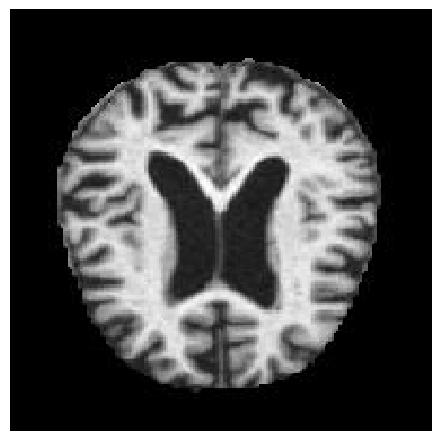

In [23]:
# Test Case 3: Moderate Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('drive/MyDrive/Alzheimer_s Dataset/test/ModerateDemented/27 (2).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = (loaded_model.predict(img) > 0.5).astype("int32")
probability = round(np.max(loaded_model.predict(img)*100),2)

print(probability, '% chances are there that the image is',idc[np.argmax(answer[0])])

The image has been classified as Moderate Demented type.
The person has moderate trace of Alzheimer's disease .

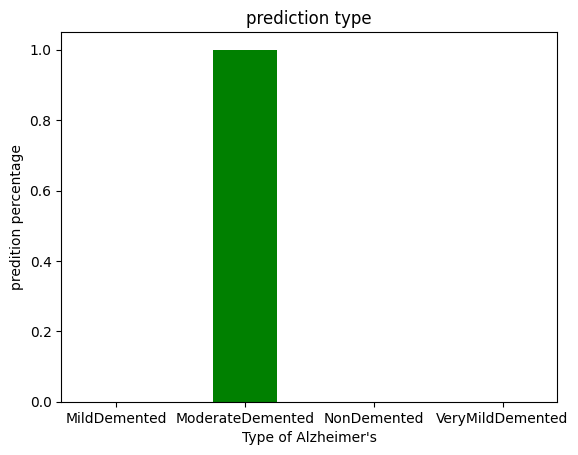

In [24]:
plt.bar(idc.values(), answer[0], width = 0.5, color = ['green'])
plt.xlabel("Type of Alzheimer's")
plt.ylabel("predition percentage")
plt.title("prediction type")
plt.show()

1/1 [==============================] - 0s 268ms/step
79.31 % chances are there that the image is VeryMildDemented


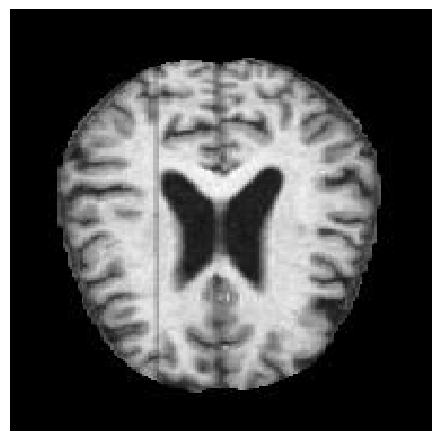

In [ ]:
# Test Case 4: Very Mild Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('drive/MyDrive/Alzheimer_s Dataset/test/VeryMildDemented/26 (54).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = (loaded_model.predict(img) > 0.5).astype("int32")
probability = round(np.max(loaded_model.predict(img)*100),2)

print(probability, '% chances are there that the image is',idc[np.argmax(answer[0])])

The image has been classified as Very Mild Demented type.
The person has a little trace of Alzheimer's disease.

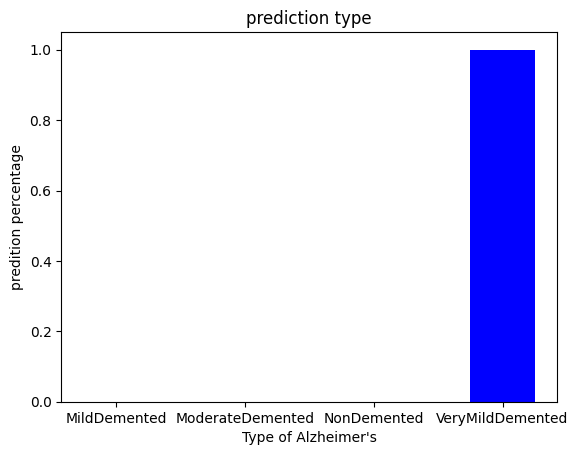

In [ ]:
plt.bar(idc.values(), answer[0], width = 0.5, color = ['blue'])
plt.xlabel("Type of Alzheimer's")
plt.ylabel("predition percentage")
plt.title("prediction type")
plt.show()

Text(0.5, 1.0, 'VeryMildDemented')

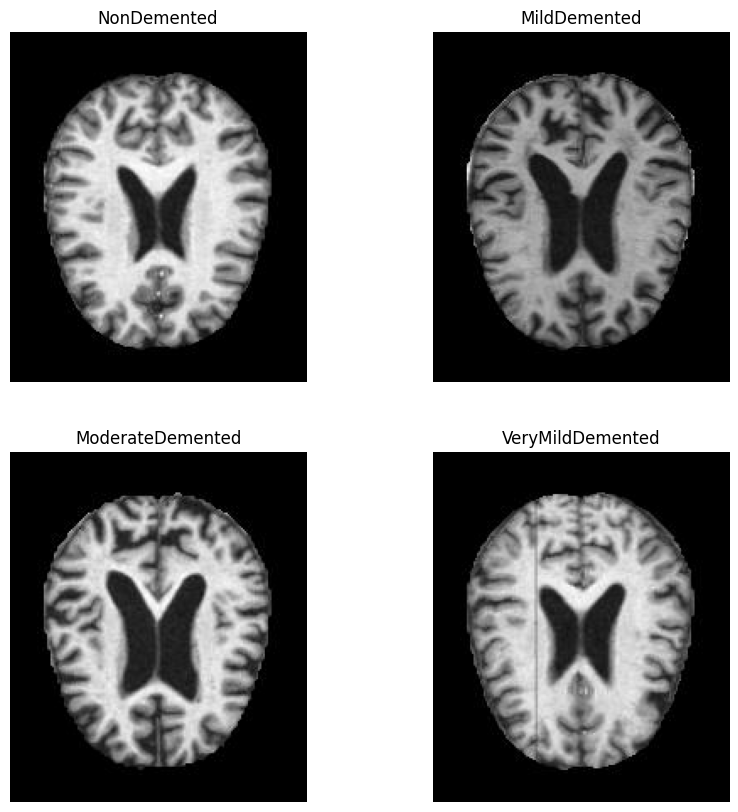

In [ ]:
import cv2
  
fig = plt.figure(figsize=(10, 10))
rows = 2
columns = 2
  
Image1 = cv2.imread('drive/MyDrive/Alzheimer_s Dataset/test/NonDemented/26 (100).jpg')
Image2 = cv2.imread('drive/MyDrive/Alzheimer_s Dataset/test/MildDemented/26 (23).jpg')
Image3 = cv2.imread('drive/MyDrive/Alzheimer_s Dataset/test/ModerateDemented/27 (2).jpg')
Image4 = cv2.imread('drive/MyDrive/Alzheimer_s Dataset/test/VeryMildDemented/26 (54).jpg')
  
# NonDemented
fig.add_subplot(rows, columns, 1)
plt.imshow(Image1)
plt.axis('off')
plt.title("NonDemented")
  
# MildDemented
fig.add_subplot(rows, columns, 2)
plt.imshow(Image2)
plt.axis('off')
plt.title("MildDemented")
  
# ModerateDemented
fig.add_subplot(rows, columns, 3)
plt.imshow(Image3)
plt.axis('off')
plt.title("ModerateDemented")
  
# VeryMildDemented
fig.add_subplot(rows, columns, 4)
plt.imshow(Image4)
plt.axis('off')
plt.title("VeryMildDemented")

Conclusion:

So, we have finally built are deep learning model using DenseNet169 transfer learning algorithm and achieved and AUC-90%.